# Tutorial for solving Bloch eigenvalue problem wiht FenicsX

In [2]:
# ################################################## #
# Genearal imports                                   #
# ################################################## #
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# ################################################## #
# Imports for plotting                               #
# ################################################## #
import matplotlib.pyplot as plt
from dolfinx.io import gmshio
import pyvista
pyvista.start_xvfb()

# ################################################## #
# Imports for the meshing                            #
# ################################################## #
import gmsh
from MeshFunctions      import get_mesh_SquareSpline,get_mesh_SquareMultiSpline
from dolfinx.plot       import create_vtk_mesh
from dolfinx.io         import XDMFFile
from dolfinx.io.gmshio  import model_to_mesh
from dolfinx.io         import gmshio

# ################################################## #
# Imports for finite element modeling                #
# ################################################## #
from mpi4py import MPI
import dolfinx_mpc
import dolfinx
from dolfinx.fem    import Function, FunctionSpace, VectorFunctionSpace
from dolfinx.mesh   import create_unit_square 
from dolfinx.mesh   import create_rectangle
from dolfinx.fem    import form
from dolfinx.fem.petsc import assemble_matrix
from dolfinx    import plot
from dolfinx.io import gmshio
from mpi4py     import MPI
from dolfinx    import fem
from ufl        import TrialFunction, TestFunction, grad, dx, dot, nabla_div, Identity, nabla_grad, inner, sym
from petsc4py.PETSc import ScalarType
from slepc4py   import SLEPc
from petsc4py   import PETSc
from typing     import List
import scipy.sparse
from scipy.sparse.linalg import eigsh
from scipy import sparse

## Define the parameters of the mesh

Here we set parameters of the problem

    a_len   -            Charecterstic unit cell length (primitive basis)

    r        -           vector of points to fit spline to

    Nquads    -          Number of quadrants to repeat spline through (radially)
    
    offset     -         Offset angle for inclusion geometry

    iscut       -        Choose if inclusion is void or an filled

    refinement_level -   Choose how much denser mesh gets around refinement field

    refinement_dist  -   Maximum distance of refinement field from refined edges
    
    isrefined        -   Choose whether or not to refine mesh around internal edges

    meshalg          -   Meshing algorithm for gmsh to use

In [3]:
start = time.time()
a_len = .1
r           = np.array([1,.2,.4])*a_len*.95
r           = a_len*np.random.rand(4,1)*.9;
offset      = np.pi/8

da                  =   a_len/15
meshalg             =   6
refinement_level    =   3
refinement_dist     =   a_len/10
Nquads      = 4

isrefined = True
cut = True


Here is an example of a design vecotor that is rotated 3 times (Nquads = 3) and the spline curve that results from it
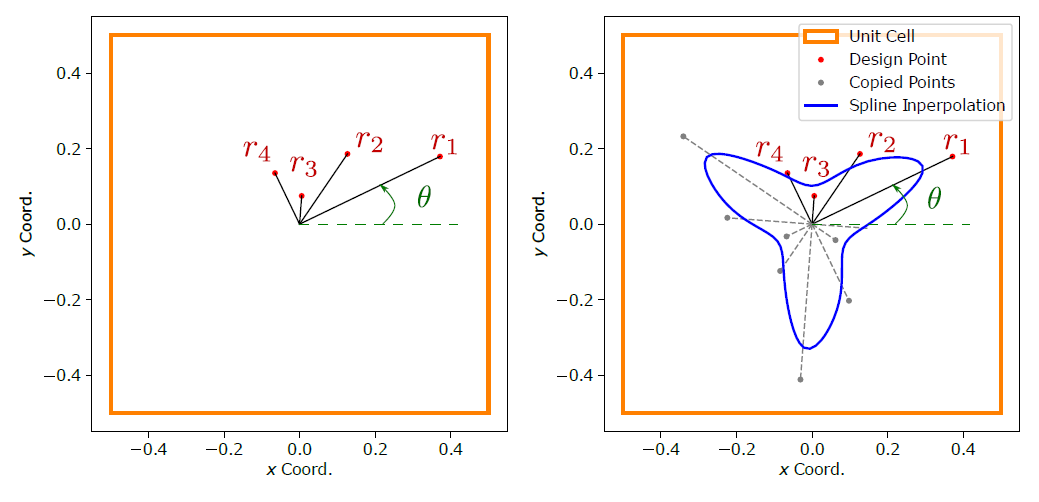

It is suggesgted to use 4-fold symmetry (Nquad  = 4) to reduce the number of high-symmetry points required to construct the dispersion diagrams

## Define the parameters of the physcial domain

Here c and rho are spped of sound and density. If cut is False, then there are two seperate physcial domains and these must be tuples. If cut is True, then the inclusion is not considered in the mesh and c and rho are scalars

In [4]:
c           = [1500,5100]
rho         = [1e3,7e3]
c           = [30]
rho         = [1.2]

## Generate the mesh

The file `Mesh_Functions` contains `get_mesh_SquareSpline`, which takes the mesh paremetrs as inputs, and creates a mesh using the `gmsh` api

In [5]:

######################################################################
#                  Generate a mesh with one inlsuion                 #
######################################################################
meshalg                 = 6
gmsh.model, xpt, ypt    = get_mesh_SquareSpline(a_len ,da,r,Nquads,offset,meshalg,
                                                refinement_level,refinement_dist,
                                                isrefined = isrefined, cut = cut)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
 --------- ERROR HERE --------------
Info    : Error in transformation from curve 2 (23-21) to 4 (24-23) (minimal transformed node distances 0 0.141421, tolerance 1.41422e-09)
Info    : Error in transformation from curve 3 (22-24) to 1 (21-22) (minimal transformed node distances 0.223607 0.1, tolerance 1.41422e-09)
 --------- ERROR HERE --------------
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.0973637s, CPU 0.101055s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0458223s, CPU 0.041418s)
Info    : 1016 nodes 2021 elements
to here


The mesh now needs to be convereted into a form dolfinx can read 

In [6]:
#################################################################
#            Import to dolfinx and save as xdmf                 #
#################################################################
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
with XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct)
t1 =  round(time.time()-start,3)
print('Generated Mesh in ' + str(t1)  + ' Seconds')    

Generated Mesh in 27.044 Seconds


We can visualize the mesh using `pyvista`

D3D12: Removing Device.

No module named 'trame'

Falling back to a static output.
  warnings.warn(



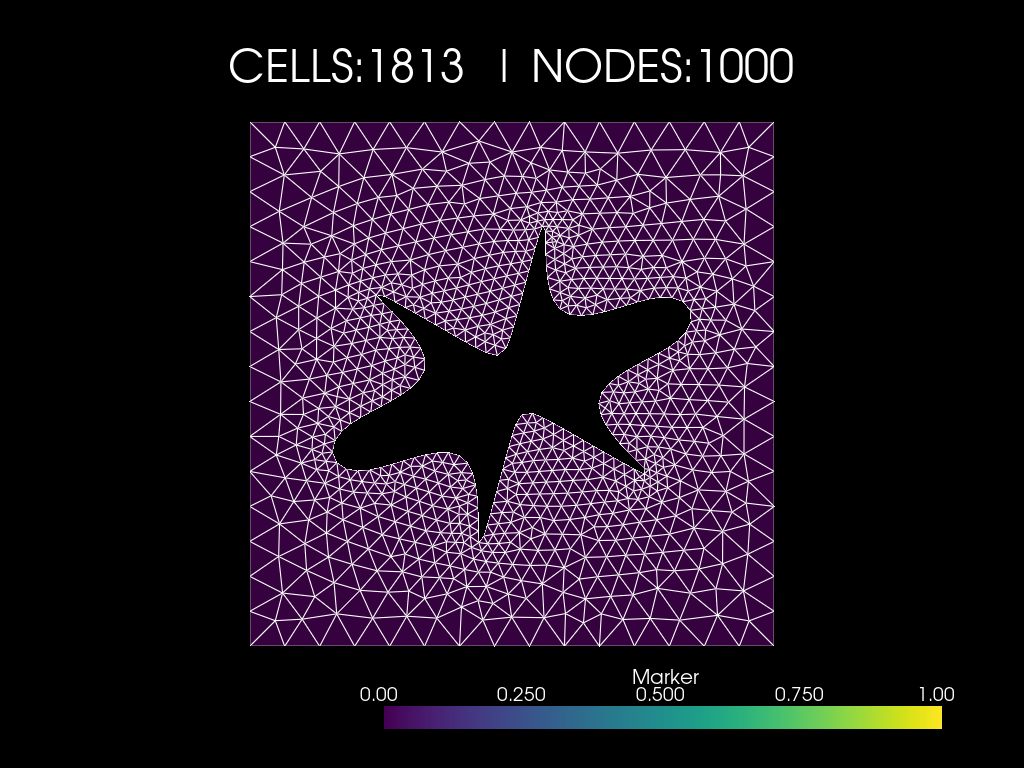

In [8]:
#################################################################
#              Plot the mesh                                    #
#################################################################
V = FunctionSpace(mesh,('CG',1))
v = Function(V)
plotter = pyvista.Plotter()
grid = pyvista.UnstructuredGrid(*create_vtk_mesh(mesh, mesh.topology.dim))
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_data["Marker"] = 1-ct.values[ct.indices<num_local_cells]
grid.set_active_scalars("Marker")
actor = plotter.add_mesh(grid, show_edges=True, line_width= 1, edge_color= 'w')
# actor = plotter.add_mesh(grid, style="wireframe", color= 'w', line_width=3)
plotter.set_background('black', top='black')
plotter.view_xy()
plotter.screenshot('Mesh.jpeg',window_size=[2000,1400])
plotter.add_title('CELLS:'+str(ct.values.shape[0])+ '  | NODES:'+str(v.vector[:].shape[0]))
plotter.show()


We can also recover the spline curve. The follow function returns the curve. The design vector is plotted as red dots and the rotated quadradnts are plotted in gray.

(-0.04186763084873087,
 0.05374556402682338,
 -0.04780659743777713,
 0.04780659743777712)

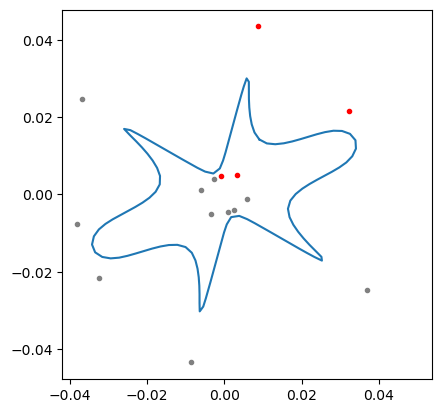

In [9]:
def GetSpline(gmsh):   
    # Get spline geometry from gmsh mesh
    node_interior = gmsh.model.mesh.getNodesForPhysicalGroup(1,5)[1]
    x_int       = node_interior[0::3]
    y_int       = node_interior[1::3]
    x_int       = np.concatenate([x_int,[x_int[0]]])
    y_int       = np.concatenate([y_int,[y_int[0]]])
    xi          = x_int - a_len/2
    yi          = y_int - a_len/2
    lxi         = len(xi)
    lxp         = len(xpt)
    xptnd       = np.array(xpt) - a_len/2
    yptnd       = np.array(ypt)- a_len/2
    lxp         = len(xptnd)
    xsv         = np.empty(xi.shape)
    SplineDat   = np.hstack( (xi.reshape(lxi,1), yi.reshape(lxi,1) ))  
    SplinePtDat = np.hstack( (xptnd.reshape(lxp,1), yptnd.reshape(lxp,1) ))  
    return SplinePtDat, SplineDat


x  = np.array(xpt) - a_len/2
y  = np.array(ypt) - a_len/2
SplinePtDat, SplineDat = GetSpline(gmsh)
# plt.scatter(SplinePtDat[:,0],SplinePtDat[:,1])
plt.plot(SplineDat[:,0],SplineDat[:,1])
plt.plot(x[0:int(len(xpt)/Nquads)], y[0:int(len(xpt)/Nquads)], ' .r')
plt.plot(x[int(len(xpt)/Nquads):-1], y[int(len(xpt)/Nquads):-1], '.', color = 'gray')
plt.axis('square')

We now define the function to create the periodic boundary, taken directly form (Link )

In [10]:
#################################################################
#       Function for multi point constraint                     #
#################################################################
def dirichlet_and_periodic_bcs(domain, functionspace, boundary_condition: List[str] = ["dirichlet", "periodic"], dbc_value = 0):
    """
    Function to set either dirichlet or periodic boundary conditions
    ----------
    boundary_condition
        First item describes b.c. on {x=0} and {x=1}
        Second item describes b.c. on {y=0} and {y=1}
    """
    
    fdim = domain.topology.dim - 1
    bcs             = []
    pbc_directions  = []
    pbc_slave_tags  = []
    pbc_is_slave    = []
    pbc_is_master   = []
    pbc_meshtags    = []
    pbc_slave_to_master_maps = []

    def generate_pbc_slave_to_master_map(i):
        def pbc_slave_to_master_map(x):
            out_x = x.copy() # was ist x.copy()?
            out_x[i] = x[i] - domain.geometry.x.max()
            return out_x
        return pbc_slave_to_master_map

    def generate_pbc_is_slave(i):
        return lambda x: np.isclose(x[i], domain.geometry.x.max())

    def generate_pbc_is_master(i):
        return lambda x: np.isclose(x[i], domain.geometry.x.min())

    # Parse boundary conditions
    for i, bc_type in enumerate(boundary_condition):
        
        if bc_type == "dirichlet":
            u_bc = fem.Function(functionspace)
            u_bc.x.array[:] = dbc_value # value of dirichlet bc needs to be passed into this function!

            def dirichletboundary(x):
                return np.logical_or(np.isclose(x[i], domain.geometry.x.min()), np.isclose(x[i], domain.geometry.x.max()))
            facets = locate_entities_boundary(domain, fdim, dirichletboundary)
            topological_dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
            bcs.append(fem.dirichletbc(u_bc, topological_dofs))
        
        elif bc_type == "periodic":
            pbc_directions.append(i)
            pbc_slave_tags.append(i + 2)
            pbc_is_slave.append(generate_pbc_is_slave(i))
            pbc_is_master.append(generate_pbc_is_master(i))
            pbc_slave_to_master_maps.append(generate_pbc_slave_to_master_map(i))

            facets = dolfinx.mesh.locate_entities_boundary(domain, fdim, pbc_is_slave[-1])
            arg_sort = np.argsort(facets)
            pbc_meshtags.append(dolfinx.mesh.meshtags(domain,
                                          fdim,
                                          facets[arg_sort],
                                          np.full(len(facets), pbc_slave_tags[-1], dtype=np.int32)))

    # Create MultiPointConstraint object
    mpc = dolfinx_mpc.MultiPointConstraint(functionspace)
    
    N_pbc = len(pbc_directions)
    for i in range(N_pbc):
        if N_pbc > 1:
            def pbc_slave_to_master_map(x):
                out_x = pbc_slave_to_master_maps[i](x)
                idx = pbc_is_slave[(i + 1) % N_pbc](x)
                out_x[pbc_directions[i]][idx] = np.nan
                return out_x
        else:
            pbc_slave_to_master_map = pbc_slave_to_master_maps[i]

        if functionspace.num_sub_spaces == 0:
            mpc.create_periodic_constraint_topological(functionspace, pbc_meshtags[i],
                                            pbc_slave_tags[i],
                                            pbc_slave_to_master_map,
                                            bcs)
        else:
            for i in range(functionspace.num_sub_spaces):
                mpc.create_periodic_constraint_topological(functionspace.sub(i), pbc_meshtags[i],
                                                pbc_slave_tags[i],
                                                pbc_slave_to_master_map,
                                                bcs)
                
    if len(pbc_directions) > 1:
        # Map intersection(slaves_x, slaves_y) to intersection(masters_x, masters_y),
        # i.e. map the slave dof at (1, 1) to the master dof at (0, 0)
        def pbc_slave_to_master_map(x):
            out_x = x.copy()
            out_x[0] = x[0] - domain.geometry.x.max()
            out_x[1] = x[1] - domain.geometry.x.max()
            idx = np.logical_and(pbc_is_slave[0](x), pbc_is_slave[1](x))
            out_x[0][~idx] = np.nan
            out_x[1][~idx] = np.nan
            return out_x
        
        if functionspace.num_sub_spaces == 0:
            mpc.create_periodic_constraint_topological(functionspace, pbc_meshtags[1],
                                                pbc_slave_tags[1],
                                                pbc_slave_to_master_map,
                                                bcs)
            
        else:
            for i in range(functionspace.num_sub_spaces):
                mpc.create_periodic_constraint_topological(functionspace.sub(i), pbc_meshtags[1],
                                                    pbc_slave_tags[1],
                                                    pbc_slave_to_master_map,
                                                    bcs)
            
    mpc.finalize()
    return mpc, bcs

Assign Physical parameters to the mesh

In [11]:
if len(rho) > 1:
    # E.g., if more than one physical group assigned.
    # Assign material propoerties to each physical group.
    Q = FunctionSpace(mesh, ("DG", 0))
    E = Function(Q)
    Rho = Function(Q)    
    material_tags   = np.unique(ct.values)
    disk1_cells     = ct.find(1)
    disk2_cells     = ct.find(2)
    Rho.x.array[disk1_cells]    = np.full_like(disk1_cells, rho[0], dtype=ScalarType)
    Rho.x.array[disk2_cells]    = np.full_like(disk2_cells, rho[1], dtype=ScalarType)
    E.x.array[disk1_cells]      = np.full_like(disk1_cells,  c[0], dtype=ScalarType)
    E.x.array[disk2_cells]      = np.full_like(disk2_cells,  c[1], dtype=ScalarType)

else:
    Rho = rho[0]
    E   = c[0]

We set the weak form for mass first, since this does not depend on wave vector and therefor anly needs to be asembled once.

In [12]:
#################################################################
#     Assign function space and constarint to mesh              #
#################################################################
V = FunctionSpace(mesh,('CG',1))
mpc, bcs = dirichlet_and_periodic_bcs(mesh, V, ["periodic", "periodic"]) 
u_tr    = TrialFunction(V)
u_test  = TestFunction(V) 
m_form = Rho*dot(u_tr, u_test)*dx


#################################################################
#        Define Mass Mat  outside of  IBZ loop                  #
#################################################################
m = form(m_form)
diagval_B = 1e-2
B = dolfinx_mpc.assemble_matrix(m, mpc, bcs=bcs, diagval=diagval_B)
B.assemble()
assert isinstance(B, PETSc.Mat)
ai, aj, av = B.getValuesCSR()
Mcomp = scipy.sparse.csr_matrix((av+0j*av, aj, ai))

Now write a function to assemble the stiffness matrix and solve the sysetm for a given set of wavector coordinates.

We solve the eigenvalue problem using scipy sparse solver (if you have the complex build of fenicsx, you could use PETSc instead)

In [19]:
def solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test):
    '''
    ===================================
        Solving the FEM proble
    ===================================
    '''
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    kx = fem.Constant(mesh,PETSc.ScalarType(kx))
    ky  = fem.Constant(mesh,PETSc.ScalarType(ky))
    a_form_re = E**2*(inner(grad(u_tr), grad(u_test)) + u_tr*u_test*(kx**2+ky**2))*dx
    a_form_im = E**2*(u_tr*inner(grad(u_test),K) - u_test*inner(grad(u_tr),K))*dx
    a_re = form(a_form_re)
    a_im = form(a_form_im)
    diagval_A = 1e8
    A_re = dolfinx_mpc.assemble_matrix(a_re, mpc, bcs=bcs, diagval=diagval_A)
    A_im = dolfinx_mpc.assemble_matrix(a_im, mpc, bcs=bcs, diagval=diagval_A)
    ############################################
    # efficient conversion to scipy for 
    # solving the complex problem (recommended)
    ############################################
    A_re.assemble()
    assert isinstance(A_re, PETSc.Mat)
    ai, aj, av = A_re.getValuesCSR()
    A_im.assemble()
    assert isinstance(A_im, PETSc.Mat)
    _,_, av_im = A_im.getValuesCSR()
    ############################################
    # Gettning solutinons
    ############################################
    Kcomp = scipy.sparse.csr_matrix((av+1j*av_im, aj, ai))
    eval, evec= eigsh(Kcomp, k = nvec, M=Mcomp, sigma = 1.0)
    return eval, evec 


Test a couple of coordinates out

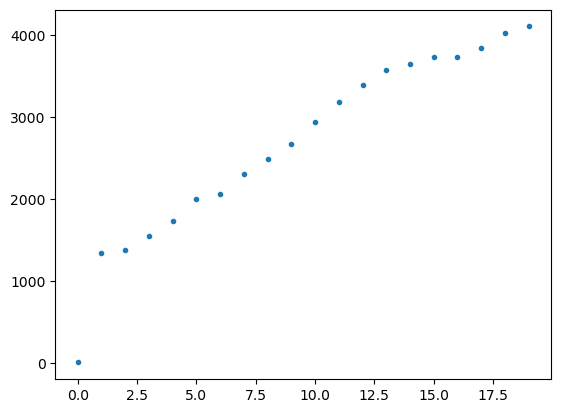

In [25]:
ky = 0
kx = .2103401
nvec = 20
K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
eval[np.isclose(eval,0)] == 0
eigfrq_sp_cmp = np.real(eval)**.5
eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )

plt.plot(eigfrq_sp_cmp,'.')

Now loop through the IBZ to compute a band structure

In [26]:
######################################################################################
#       ---             LOOPING THROUGH THE IBZ              ---                     #
######################################################################################

np1  = 20
np2  = 20
np3  = 20
nvec = 20

ky = 0
tsolve = []
evals_disp =[]
maxk = np.pi/a_len
start=time.time()
evec_all = []
print('Computing Band Structure .... ')
#################################################################
#            Computing K to M                                   #
#################################################################
print('Computing Gamma to  X')
for kx in np.linspace(0.01,maxk,np1):
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)
    
#################################################################
#            Computing K to M                                   #
#################################################################
print('Computing X to  M')
kx = maxk
for ky in np.linspace(0.01,maxk,np2):
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    # start=time.time()
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)

#################################################################
#            Computing M To Gamma                               #
#################################################################
print('Computing M to Gamma')
for kx in np.linspace(maxk,0.01,np3):
    ky = kx
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    # start=time.time()
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp)
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)
    # print(np.round(time.time()-start,3))
# print(np.round(time.time()-start,3))

Computing Band Structure .... 
Computing Gamma to  X
Computing X to  M
Computing M to Gamma


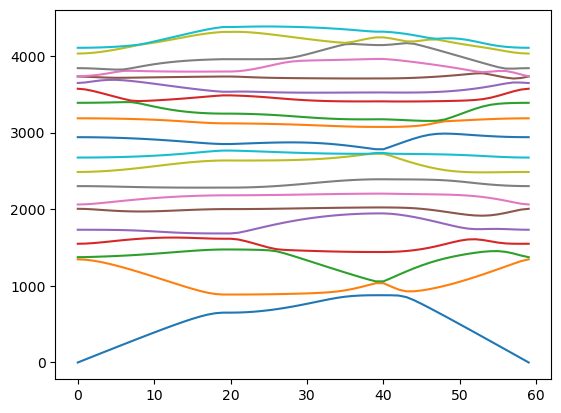

In [27]:
plt.plot(np.array(evals_disp))

Visualize the eigenvectors

  mycmap = plt.cm.get_cmap('seismic', 10)




No module named 'trame'

Falling back to a static output.
  warnings.warn(



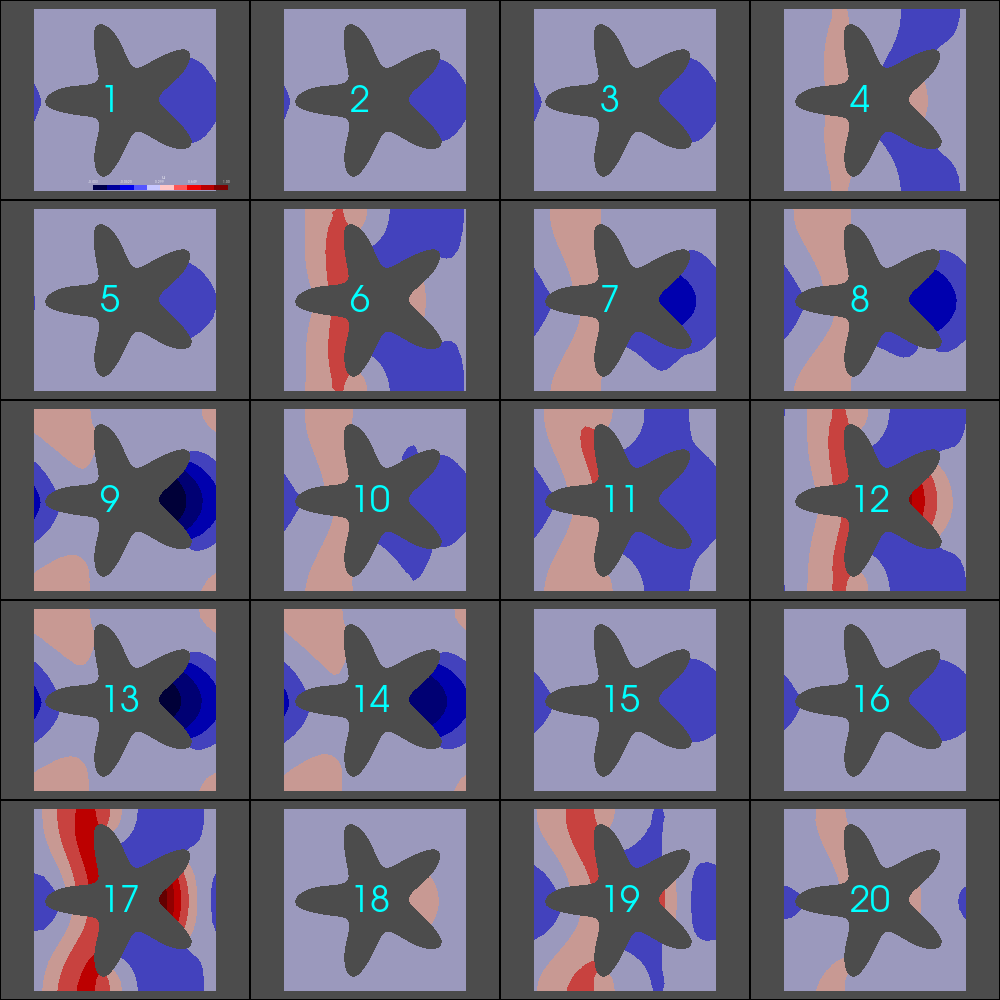

In [33]:
testload = np.array(evec_all) #np.load('data//testFile.npy')
plotter = pyvista.Plotter(shape=(5,4) , window_size=(1000,1000))
###########################################################
# Post-processing the eigenvectors
###########################################################
euse = 0
for i in range(5):
    for j in range(4):
        plotter.subplot(i,j)
        et = testload[euse,:,3]; euse += 1
        vr = Function(V)
        vi = Function(V)
        vr.vector[:] = np.real(et)
        vi.vector[:] = np.imag(et)
        vr.x.scatter_forward()
        mpc.backsubstitution(vr.vector)
        vi.x.scatter_forward()
        mpc.backsubstitution(vi.vector)


        ###########################################################
        # Plotting eigenvectors with pyvista
        ###########################################################
        # mycmap = plt.cm.get_cmap('coolwarm', 10)
        mycmap = plt.cm.get_cmap('seismic', 10)
        u = Function(V)
        cells, types, x = plot.create_vtk_mesh(V)
        grid = pyvista.UnstructuredGrid(cells, types, x)
        grid.point_data["u"] = u.x.array
        u.vector.setArray(vr.vector[:]/np.max(vr.vector[:])*np.sign(vr.vector[10]))
        edges = grid.extract_all_edges()
        warped = grid.warp_by_scalar("u", factor=0)
        plotter.add_mesh(warped, show_edges=False, show_scalar_bar=True, scalars="u",cmap=mycmap)
        # plotter.add_mesh(grid, style = 'wireframe', line_width = .5, color = 'black')
        plotter.view_xy()
        plotter.add_text(str(euse), position=[100,80], color='cyan')
        plotter.camera.tight(padding=0.1)
plotter.show()